# **Picking A Dataset**

https://www.kaggle.com/datasets/atharvasoundankar/global-cybersecurity-threats-2015-2024/data

I picked this data for many reasons:
1. its about cybersecurity.
2. it includes many features and sampels which helps with building models and clustering.
3. and it covers a decade worth of incidents while having recent events.

My goal is to research this data and to build a model classifying incidient resultion time.

# **System Stage**

**• File system**
- Name: Global_Cybersecurity_Threats_2015-2024.csv 
- Size: 251KB, zipped: 47KB 
- Type: Comma-separated values (CSV)

**• Protocols**
- Accessed and downloaded via HTTPS


**• Web information**
- Source: Kaggle
- Created by: Atharva Soundankar.
- The owner referenced these sources:<br>
•	Verizon Data Breach Investigations Report (DBIR)<br>
•	ENISA Threat Landscape Reports<br>
•	MITRE ATT&CK Framework<br>
•	Public whitepapers from vendors such as Symantec, CrowdStrike, and FireEye<br>
•	CERT advisories and national cybersecurity archives

**Version control**
- Main version "Global_Cybersecurity_Threats_2015-2024" uploaded 2024 and was last edited in March 2025.
- i also added another 3 versions:

| File Name                       | how to get it                                    |
|---------------------------------|--------------------------------------------------|
| dataset_with_all_outlier_flags  | Running abnormality detection downloads the version |
| df_gmm_clusters (outliers removed) | Running clustering downloads the version         |
| df_kmeans_clusters (outliers removed) | Running clustering downloads the version      |

# **meta data**

Number of rows: 3000, Number of columns: 10


,Feature,Type,Unique Values
0,Country,string,10
1,Year,int64,10
2,Attack Type,string,6
3,Target Industry,string,7
4,Financial Loss (in Million $),float64,2536
5,Number of Affected Users,int64,2998
6,Attack Source,string,4
7,Security Vulnerability Type,string,4
8,Defense Mechanism Used,string,5
9,Incident Resolution Time (in Hours),int64,72


Column 'Year' has values below zero: False
Column 'Financial Loss (in Million $)' has values below zero: False
Column 'Number of Affected Users' has values below zero: False
Column 'Incident Resolution Time (in Hours)' has values below zero: False


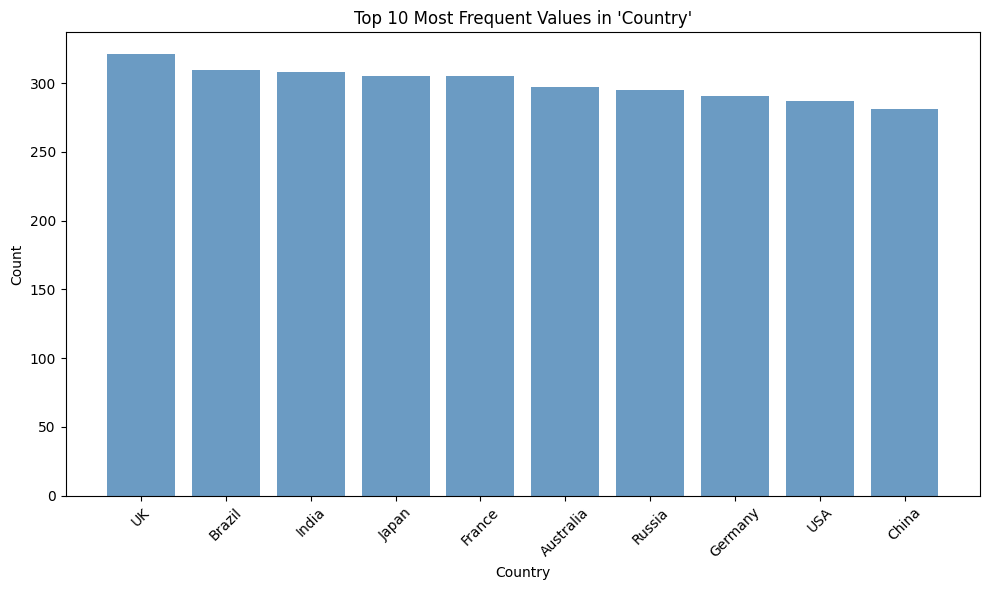

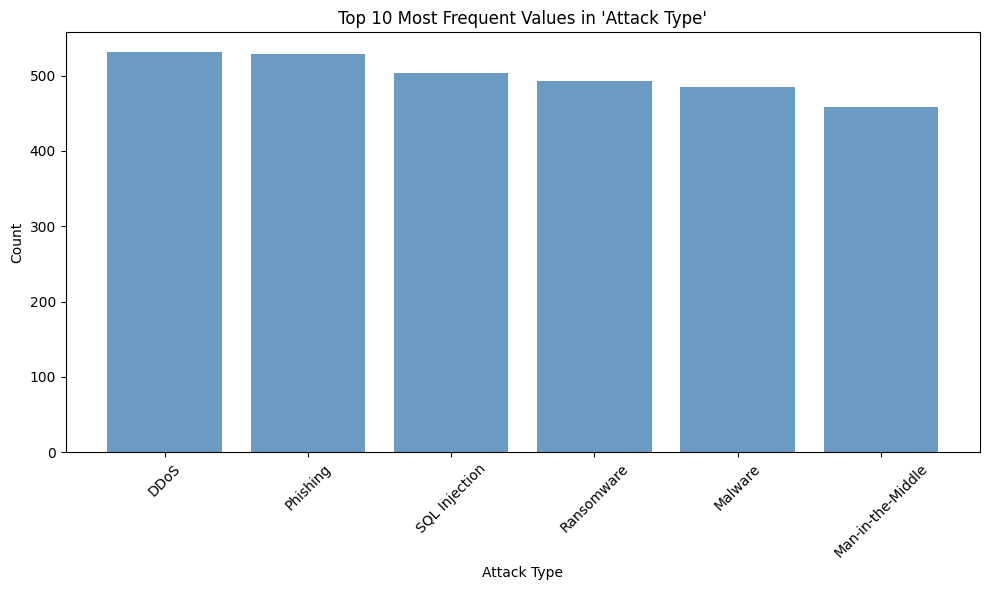

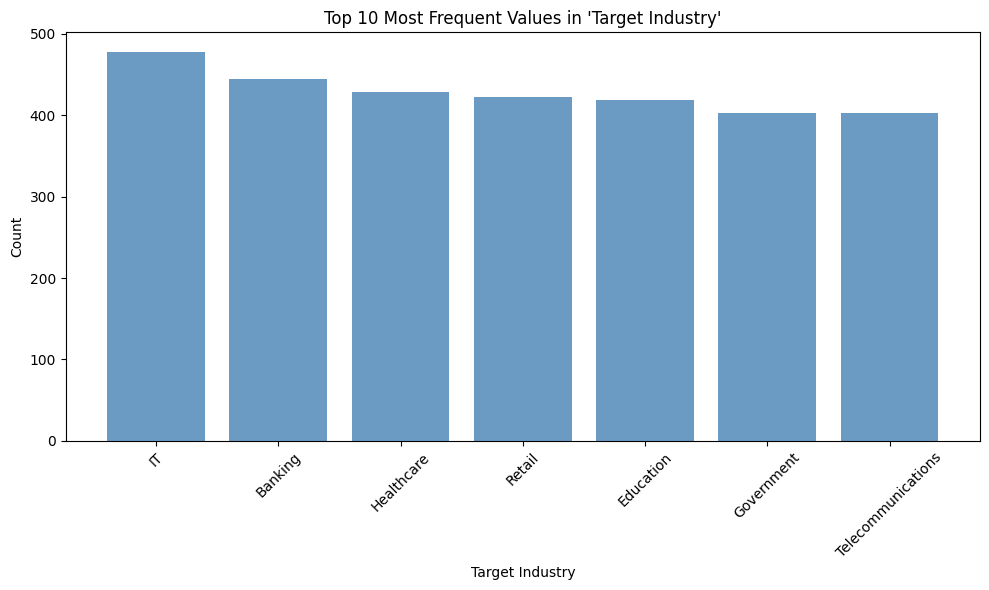

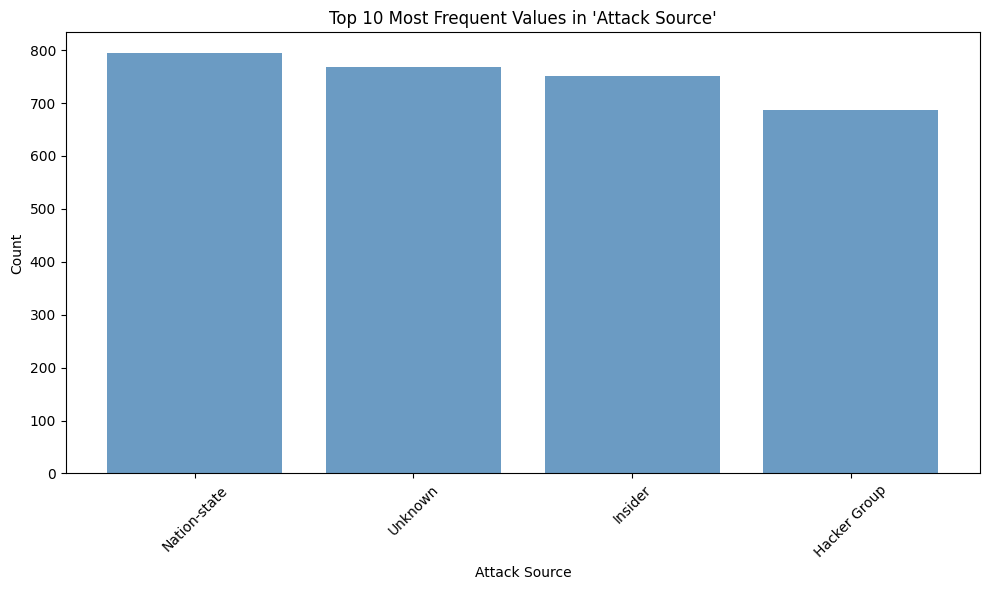

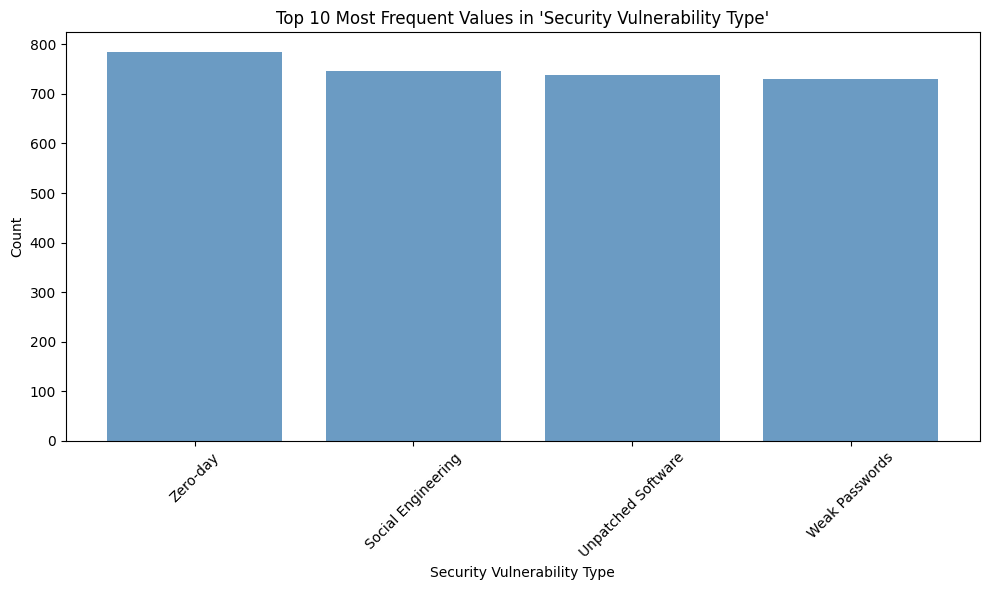

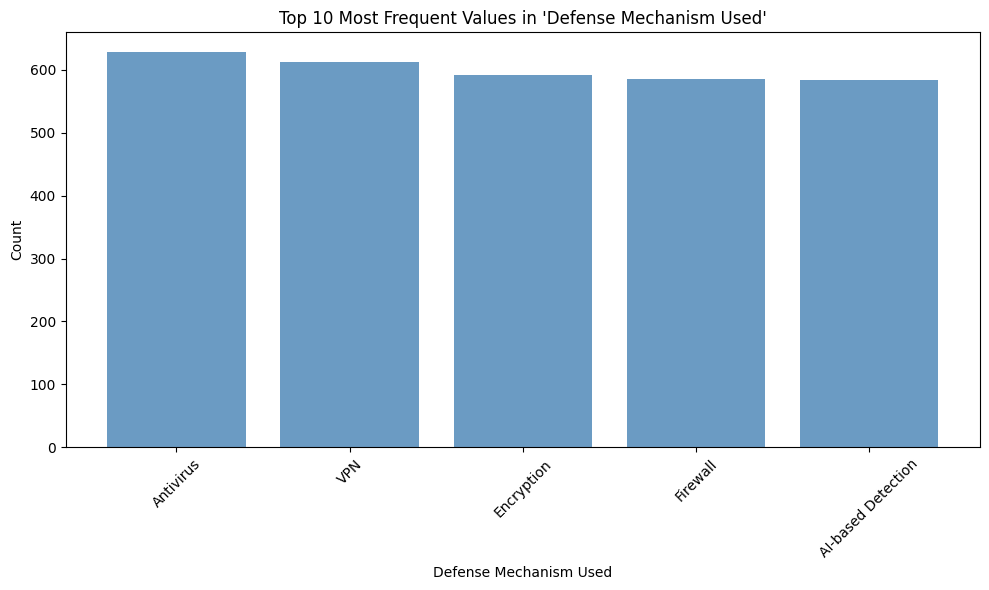

In [1]:
# %pip install pandas
# %pip install ace_tools
# %pip install matplotlib
from IPython.display import display
import pandas as pd
import matplotlib.pyplot as plt

# Replace 'data.csv' with your file path
df = pd.read_csv('Global_Cybersecurity_Threats_2015-2024.csv')

# Dictionary to hold value counts for each column
unique_values_summary = {}

summary = pd.DataFrame({
    "Feature": df.columns,
    "Type": [("string" if df[col].dtype == "object" else df[col].dtype.name) for col in df.columns],
    "Unique Values": [df[col].nunique(dropna=False) for col in df.columns]
})
# print the number of rows and columns
print(f"Number of rows: {df.shape[0]}, Number of columns: {df.shape[1]}")

# Display the result
display(summary.style.set_properties(**{'text-align': 'left'}))

# Assuming your DataFrame is named df
numeric_cols = df.select_dtypes(include=['int64', 'float64']).columns

for col in numeric_cols:
    has_below_zero = (df[col] < 0).any()
    print(f"Column '{col}' has values below zero: {has_below_zero}")

textual_features = df.select_dtypes(include=['object']).columns.tolist()

# Plotting the top 10 most frequent values for each textual feature
for col in textual_features:
    value_counts = df[col].value_counts().head(10)
    plt.figure(figsize=(10, 6))
    plt.bar(value_counts.index.astype(str), value_counts.values, color='steelblue', alpha=0.8)
    plt.xlabel(col)
    plt.ylabel("Count")
    plt.title(f"Top 10 Most Frequent Values in '{col}'")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

as we can see in the numerical features all of the data is correct (there are no negative values and the years are from 2015-2024).
but with textual features we can clearly see that in the 'attack source' feature there is an "unknown" value. i wont remove the value (yet) because it might be usefull for the future.

# **Statistics**

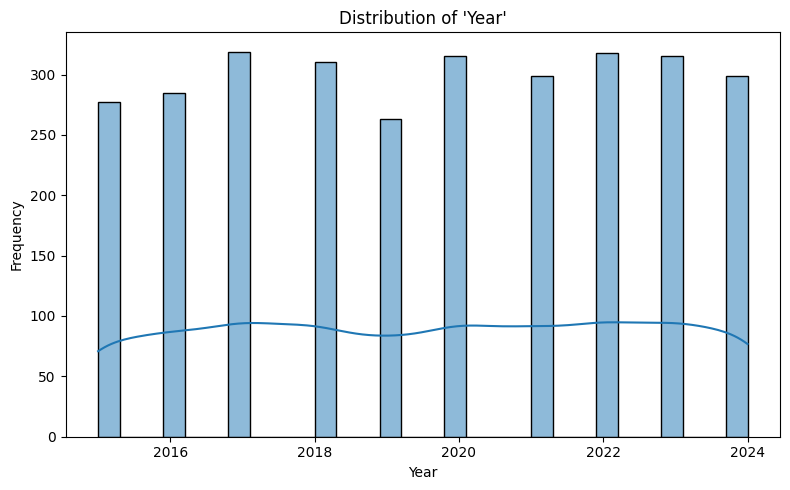

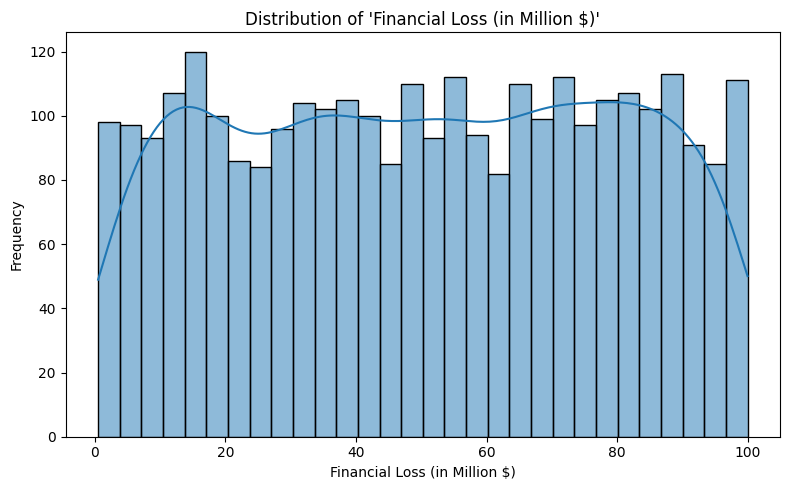

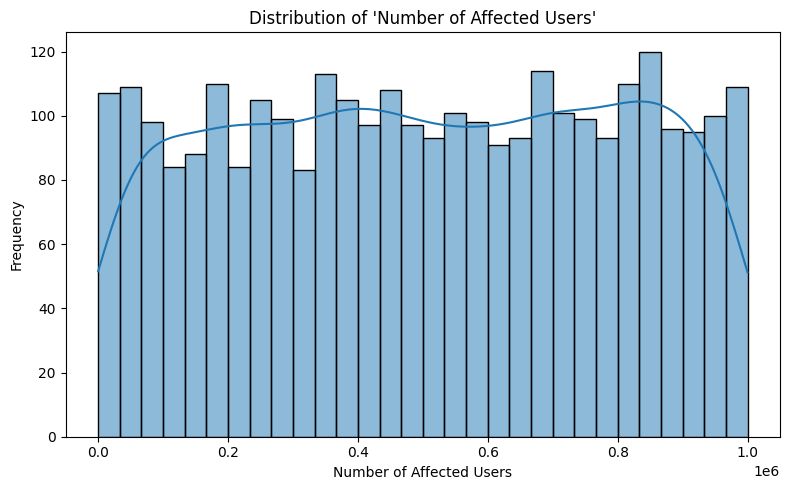

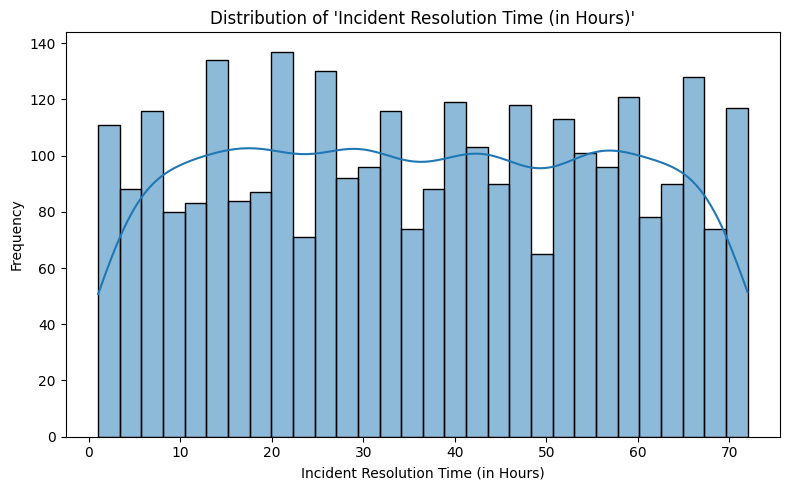


--- Central Tendencies for Numeric Features ---


,Mean,Median,Mode,Min,Max,Standard Deviation
Year,2019.570333,2020.000000,2017.000000,2015.000000,2024.000000,2.857932
Financial Loss (in Million $),50.492970,50.795000,17.990000,0.500000,99.990000,28.791415
Number of Affected Users,504684.136333,504513.000000,164890.000000,424.000000,999635.000000,289944.084972
Incident Resolution Time (in Hours),36.476000,37.000000,43.000000,1.000000,72.000000,20.570768


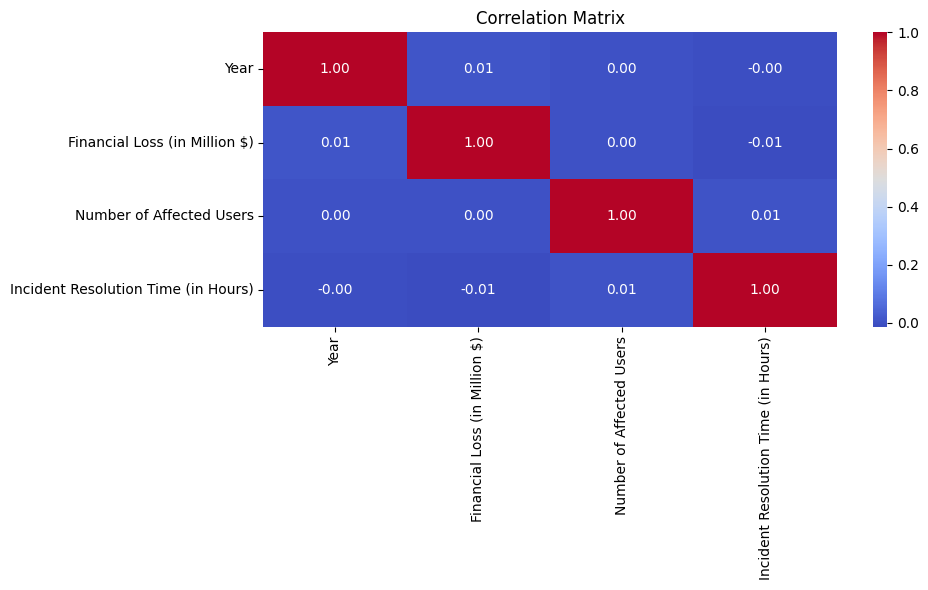

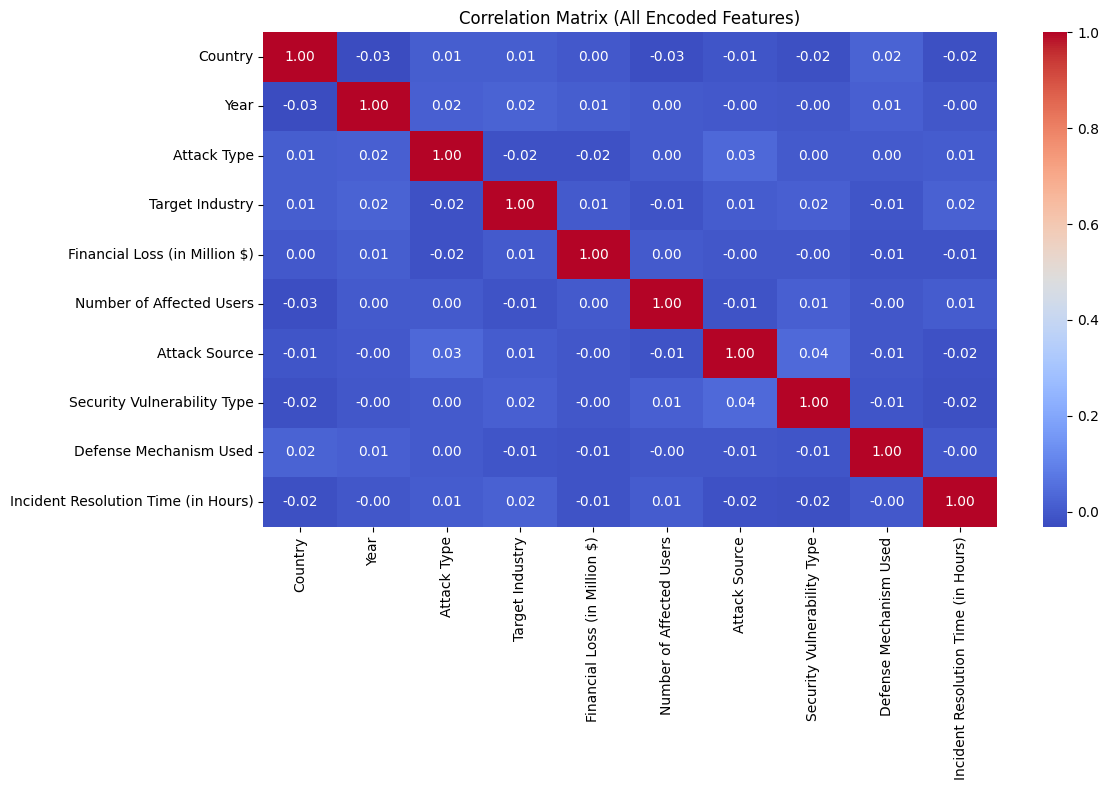

Number of duplicate rows: 0


,Cramer's V,p-value,Feature 1,Feature 2
0,0.062019,0.010559,Target Industry,Attack Source
1,0.056436,0.368902,Country,Defense Mechanism Used
2,0.053821,0.514690,Country,Security Vulnerability Type
3,0.052670,0.616301,Country,Attack Type
4,0.052525,0.642349,Country,Target Industry


Target Industry,Banking,Education,Government,Healthcare,IT,Retail,Telecommunications
Attack Source,,,,,,,
Hacker Group,94,80,101,104,111,99,97
Insider,126,126,95,103,108,91,103
Nation-state,122,125,101,101,110,125,110
Unknown,103,88,106,121,149,108,93


In [ ]:
# %pip install seaborn
# %pip install scikit-learn
# %pip install jinja2
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
import pandas as pd
import numpy as np
from scipy.stats import chi2_contingency


# 2. Distribution plots for numeric features
numeric_cols = df.select_dtypes(include='number').columns
for col in numeric_cols:
    plt.figure(figsize=(8, 5))
    sns.histplot(df[col], kde=True, bins=30)
    plt.title(f"Distribution of '{col}'")
    plt.xlabel(col)
    plt.ylabel("Frequency")
    plt.tight_layout()
    plt.show()

# 3. Calculate central tendencies
central_tendencies = pd.DataFrame({
    "Mean": df[numeric_cols].mean(),
    "Median": df[numeric_cols].median(),
    "Mode": df[numeric_cols].mode().iloc[0],
    "Min": df[numeric_cols].min(),
    "Max": df[numeric_cols].max(),
    "Standard Deviation": df[numeric_cols].std(),
})

print("\n--- Central Tendencies for Numeric Features ---")
display(central_tendencies.style.set_properties(**{'text-align': 'left'}))

# 4. Correlation matrix
plt.figure(figsize=(10, 6))
corr = df[numeric_cols].corr()
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Matrix")
plt.tight_layout()
plt.show()



encoded_df = df.copy()

# Label encode all object (textual) columns
label_encoders = {}
for col in encoded_df.select_dtypes(include='object').columns:
    le = LabelEncoder()
    encoded_df[col] = le.fit_transform(encoded_df[col].astype(str))
    label_encoders[col] = le

# Compute the full correlation matrix
correlation_matrix = encoded_df.corr()

# Plot heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Matrix (All Encoded Features)")
plt.tight_layout()
plt.show()

# check for duplicate rows
duplicates = df.duplicated().sum()
print(f"Number of duplicate rows: {duplicates}")


# ---------- helper ----------
def cramers_v(confusion):
    chi2, _, _, _ = chi2_contingency(confusion)
    n = confusion.sum().sum()
    r, k = confusion.shape
    return np.sqrt(chi2 / (n * (min(r, k) - 1)))

# list categorical columns with ≤15 unique labels
cat_cols = df.select_dtypes('object').columns
small = [c for c in cat_cols if df[c].nunique() <= 15]

# brute-force search for stronger associations
from itertools import combinations
best = []
for c1, c2 in combinations(small, 2):
    ct = pd.crosstab(df[c1], df[c2])
    if (ct.values < 5).sum():
        print(f"Skipped {c1}, {c2} due to small cells")
        continue
    p = chi2_contingency(ct)[1]
    v = cramers_v(ct)
    best.append((v, p, c1, c2))
best = sorted(best, reverse=True)[:5]
display(pd.DataFrame(best, columns=['Cramer\'s V', 'p-value', 'Feature 1', 'Feature 2']).style.set_properties(**{'text-align': 'left'}))


# ---------- example ----------
cat1, cat2 = 'Attack Source', 'Target Industry'   # <-- pick any two
# cat1, cat2 = 'Attack Source', 'Security Vulnerability Type'   # <-- pick any two
ct = pd.crosstab(df[cat1], df[cat2])              # Crosstab
chi2_p = chi2_contingency(ct)[1]                  # p-value
cv = cramers_v(ct)                                # Cramer's V   (0–1 strength)
display(ct)


we can see that dimension reduction(PCA) wont work because the correlation between the features is 0. <br>
i put 2 types of correlations, one where i encoded the textual features, and the other i kept to see the correaltion between the numeric features better.

Association wise: i checked the top5 lowest p-value and showed the crosstab of 2 with the lowest p-value, also we can see that the p-value is very high for all the other features which means the categories arent dependent on one anohter.

# **Abnormality detection**

In [34]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor
from scipy.stats import median_abs_deviation
from sklearn.svm import OneClassSVM


# -----------------------------------------------------------
# 0. LOAD DATA
# -----------------------------------------------------------
df = pd.read_csv("Global_Cybersecurity_Threats_2015-2024.csv")

num_cols = df.select_dtypes(include='number').columns.tolist()
cat_cols = df.select_dtypes(include='object').columns.tolist()

# -----------------------------------------------------------
# 1. UNIVARIATE NUMERIC OUTLIERS  (Z-score rule)
# -----------------------------------------------------------
for col in num_cols:
    z = (df[col] - df[col].mean()) / df[col].std(ddof=0)
    df[f"{col}_z_outlier"] = z.abs() > 3          # True ⇢ outlier

print("\n--- Z-Score Outliers per Numeric Feature ---")
for col in num_cols:
    print(f"{col}: {df[f'{col}_z_outlier'].sum()}")

# -----------------------------------------------------------
# 2. UNIVARIATE CATEGORICAL “RARE-LEVEL” OUTLIERS
#    (levels whose frequency < min_freq_pct)
# -----------------------------------------------------------
min_freq_pct = 0.01          # 1 % threshold

for col in cat_cols:
    freq = df[col].value_counts(normalize=True)
    rare_levels = freq[freq < min_freq_pct].index
    df[f"{col}_rare_level"] = df[col].isin(rare_levels)

print(f"\n--- Rare-Level Outliers (< {min_freq_pct*100:.1f}% per column) ---")
for col in cat_cols:
    rare_count = df[f"{col}_rare_level"].sum()
    print(f"{col}: {rare_count} rows flagged")


# -----------------------------------------------------------
# 3. Univariate MAD + IQR
# -----------------------------------------------------------

outlier_flags = {}
for col in num_cols:
    x = df[col].dropna()
    # ---- MAD ----
    med = x.median()
    mad = median_abs_deviation(x, scale='normal')   # consistent with σ
    mad_mask = (df[col] - med).abs() > 3 * mad      # 3-σ rule analogue

    # ---- IQR ----
    q1, q3 = x.quantile([0.25, 0.75])
    iqr_mask = ( (df[col] < q1 - 1.5*(q3-q1)) |
                 (df[col] > q3 + 1.5*(q3-q1)) )

    outlier_flags[col+'_mad'] = mad_mask
    outlier_flags[col+'_iqr'] = iqr_mask

outliers = pd.DataFrame(outlier_flags)
df_clean = df[~outliers.any(axis=1)]

summary = []
N = len(df)

for col in num_cols:                        # ← same num_cols list you already built
    mad_cnt = outlier_flags[f'{col}_mad'].sum()
    iqr_cnt = outlier_flags[f'{col}_iqr'].sum()
    summary.append({
        'feature': col,
        'MAD_outliers':  mad_cnt,
        'MAD_%': 100 * mad_cnt / N,
        'IQR_outliers': iqr_cnt,
        'IQR_%': 100 * iqr_cnt / N
    })

mad_iqr_summary = (pd.DataFrame(summary)
                     .sort_values(['MAD_outliers', 'IQR_outliers'], ascending=False))

print("\n=== Univariate outlier counts (MAD & IQR) ===")
print(mad_iqr_summary.to_string(index=False, formatters={
    'MAD_%': '{:.1f}'.format, 'IQR_%': '{:.1f}'.format}))


# -----------------------------------------------------------
# 4. single-class SVM.
# -----------------------------------------------------------


X = df[num_cols].fillna(df[num_cols].median())
X_scaled = StandardScaler().fit_transform(X)

ocsvm = OneClassSVM(kernel='rbf', nu=0.05, gamma='auto').fit(X_scaled)
df['svm_outlier'] = ocsvm.predict(X_scaled) == -1   # −1 = anomaly

svm_outliers = df['svm_outlier'].sum()
print(f"\nOne-Class SVM flagged {svm_outliers} rows "
      f"({svm_outliers / N:.2%}) as multivariate anomalies.")




# -----------------------------------------------------------
# 5. ISOLATION FOREST  (multivariate)
# -----------------------------------------------------------
df_if = df.copy()

# Label-encode categoricals
label_encoders = {}
for col in cat_cols:
    le = LabelEncoder()
    df_if[col] = le.fit_transform(df_if[col].astype(str))
    label_encoders[col] = le

iso = IsolationForest(
    n_estimators=100,
    contamination=0.05,
    random_state=42
)
df_if["IF_label"] = iso.fit_predict(df_if[num_cols + cat_cols])
df["IF_outlier"] = df_if["IF_label"] == -1

print(f"\nIsolation Forest detected {df['IF_outlier'].sum()} outliers.")

# -----------------------------------------------------------
# 6. LOCAL OUTLIER FACTOR  (multivariate, local)
# -----------------------------------------------------------
# Build numeric matrix (encoded cats + scaled)
df_lof = df_if[num_cols + cat_cols].copy()
X_lof = StandardScaler().fit_transform(df_lof)

lof = LocalOutlierFactor(
    n_neighbors=20,
    contamination=0.05
)
lof_labels = lof.fit_predict(X_lof)
df["LOF_outlier"] = lof_labels == -1

print(f"LOF detected {df['LOF_outlier'].sum()} outliers.")

# -----------------------------------------------------------
# 7. SAVE OR INSPECT (optional)
# -----------------------------------------------------------
df.to_csv("dataset_with_all_outlier_flags.csv", index=False)


# Find rows flagged by all 3 methods
all_outliers = df[(df["IF_outlier"]) | (df["LOF_outlier"]) | (df["svm_outlier"])]

print(f"Number of outliers flagged by ALL methods: {all_outliers.shape[0]}")





--- Z-Score Outliers per Numeric Feature ---
Year: 0
Financial Loss (in Million $): 0
Number of Affected Users: 0
Incident Resolution Time (in Hours): 0

--- Rare-Level Outliers (< 1.0% per column) ---
Country: 0 rows flagged
Attack Type: 0 rows flagged
Target Industry: 0 rows flagged
Attack Source: 0 rows flagged
Security Vulnerability Type: 0 rows flagged
Defense Mechanism Used: 0 rows flagged

=== Univariate outlier counts (MAD & IQR) ===
                            feature  MAD_outliers MAD_%  IQR_outliers IQR_%
                               Year             0   0.0             0   0.0
      Financial Loss (in Million $)             0   0.0             0   0.0
           Number of Affected Users             0   0.0             0   0.0
Incident Resolution Time (in Hours)             0   0.0             0   0.0

One-Class SVM flagged 149 rows (4.97%) as multivariate anomalies.

Isolation Forest detected 150 outliers.
LOF detected 150 outliers.
Number of outliers flagged by ALL meth

using univariate outliers: we didnt find any outliers even after lowering the thresholds. <br>
using multivariate outliers: using IF, LOF and single-class SVM we found 150 outliers with each with 312 total different outliers.
<br><br>
explaintions to why this might happen:<br>
we got no univariate outliers because Each feature on its own looks normal. None of the values break the Z-score / rare-level cut-offs, so univariate tests stay silent. but multivariate outliers (IF and LOF) judge the dataset using combo of features, so a sample can look perfectly nomral on its own but when looking at everything together it might look weird.

# **Clustering**

Dropped 215 rows as outliers; 2785 rows remain for clustering.


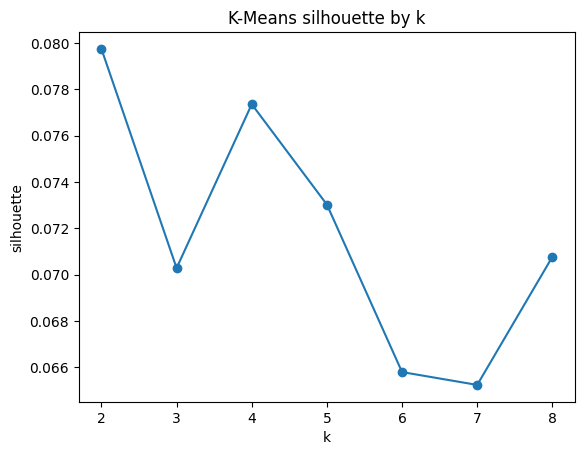

Best k = 2  (silhouette = 0.080)

Cluster sizes:
 cluster
0    1397
1    1388
Name: count, dtype: int64


In [56]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

# ------------------------------------------------------------------
# 1) LOAD DATA (this CSV must already contain the outlier-flag columns
#    you created in Step 5).  If you still have df in memory, skip this.
# ------------------------------------------------------------------
df = pd.read_csv("dataset_with_all_outlier_flags.csv")

# ------------------------------------------------------------------
# 2) DROP EVERY TYPE OF OUTLIER
# ------------------------------------------------------------------
flag_cols = [
    c for c in df.columns
    if (c.endswith("_outlier") or c.endswith("_rare_level")) and c != "svm_outlier"
]
df_cln_1 = df[~df[flag_cols].any(axis=1)].reset_index(drop=True)
flag_cols = [c for c in df.columns if c.endswith("_outlier") or c.endswith("_rare_level")]
df_cln_1.drop(columns=flag_cols, inplace=True)  # remove the flags

print(f"Dropped {len(df) - len(df_cln_1)} rows as outliers; "
      f"{len(df_cln_1)} rows remain for clustering.")

# ------------------------------------------------------------------
# 3) BUILD FEATURE MATRIX (remove the flag columns first)
# ------------------------------------------------------------------
num_cols = [c for c in df_cln_1.select_dtypes(include="number").columns
            if c not in flag_cols]          # keep numeric, drop flags
cat_cols = [c for c in df_cln_1.select_dtypes(include="object").columns]

pre = ColumnTransformer([
    ("num", StandardScaler(), num_cols),
    ("cat", OneHotEncoder(handle_unknown="ignore", sparse_output=False), cat_cols)
])

X = pre.fit_transform(df_cln_1)

# ------------------------------------------------------------------
# 4) PICK BEST k (2-8) BY SILHOUETTE & FIT K-MEANS
# ------------------------------------------------------------------

k_vals, sil_scores = [], []
best_k, best_score = None, -1
for k in range(2, 9):
    labels = KMeans(n_clusters=k, random_state=42, n_init='auto').fit_predict(X)
    score  = silhouette_score(X, labels)
    if score > best_score:
        best_k, best_score, best_labels = k, score, labels
    k_vals.append(k)
    sil_scores.append(silhouette_score(X, labels))

plt.plot(k_vals, sil_scores, marker='o')
plt.xlabel('k'); plt.ylabel('silhouette')
plt.title('K-Means silhouette by k'); plt.show()

df_cln_1["cluster"] = best_labels
print(f"Best k = {best_k}  (silhouette = {best_score:.3f})")
print("\nCluster sizes:\n", df_cln_1["cluster"].value_counts().sort_index())



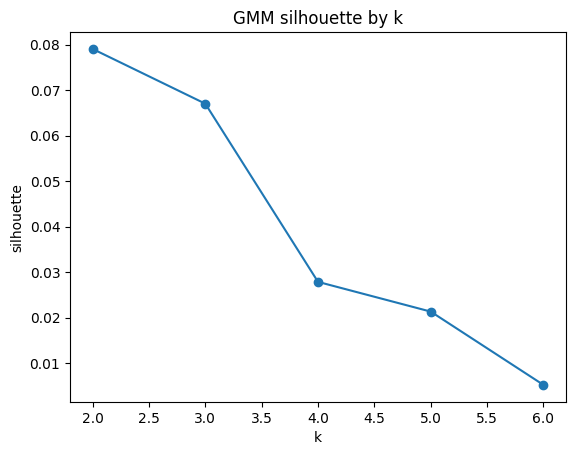

Best k = 2  (silhouette = 0.128)

Cluster sizes:
 cluster
0    1406
1    1379
Name: count, dtype: int64


In [57]:
from sklearn.decomposition import PCA
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score

# X = preprocessed matrix from earlier
df = pd.read_csv("dataset_with_all_outlier_flags.csv")

flag_cols = [
    c for c in df.columns
    if (c.endswith("_outlier") or c.endswith("_rare_level")) and c != "svm_outlier"
]
df_cln_2 = df[~df[flag_cols].any(axis=1)].reset_index(drop=True)
flag_cols = [c for c in df.columns if c.endswith("_outlier") or c.endswith("_rare_level")]
df_cln_2.drop(columns=flag_cols, inplace=True)  # remove the flags

X_pca = PCA(n_components=10, random_state=42).fit_transform(X)

k_vals, sil_scores = [], []
best_k, best_sil = None, -1
for k in range(2,7):
    gmm = GaussianMixture(k, random_state=42)
    labels = gmm.fit_predict(X_pca)
    sil = silhouette_score(X_pca, labels)
    # print(f'k={k}, silhouette={sil:.3f}')
    if sil > best_sil:
        best_k, best_sil, best_labels = k, sil, labels
    k_vals.append(k)
    sil_scores.append(silhouette_score(X, labels))

plt.plot(k_vals, sil_scores, marker='o')
plt.xlabel('k'); plt.ylabel('silhouette')
plt.title('GMM silhouette by k'); plt.show()

df_cln_2["cluster"] = best_labels
print(f"Best k = {best_k}  (silhouette = {best_sil:.3f})")
print("\nCluster sizes:\n", df_cln_2["cluster"].value_counts().sort_index())

# ------------- save cluster-labelled dfs ----------
df_cln_1.to_csv("df_kmeans_clusters.csv", index=False)
df_cln_2.to_csv("df_gmm_clusters.csv", index=False)


I ran two clustering tricks:

1. K-Means (tried k = 2-8) → best silhouette ≈ 0.08 at k = 2.

2. PCA (10 dims) + Gaussian Mixture → best silhouette ≈ 0.13, also k = 2.

both methods agree on two broad clusters of almost equal size (~1.4 k rows each).

# **Segment analysis**


=== Cluster Kmeans Analysis ===

=== Numeric medians by cluster ===


,Year,Financial Loss (in Million $),Number of Affected Users,Incident Resolution Time (in Hours)
cluster,,,,
0,2020.0,52.31,488599.0,19.0
1,2020.0,49.26,512979.0,54.0


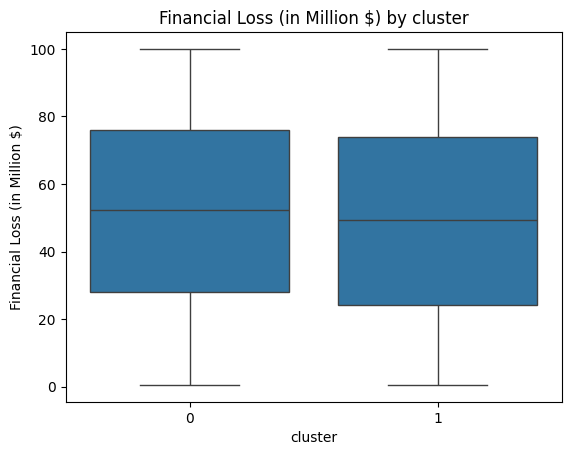

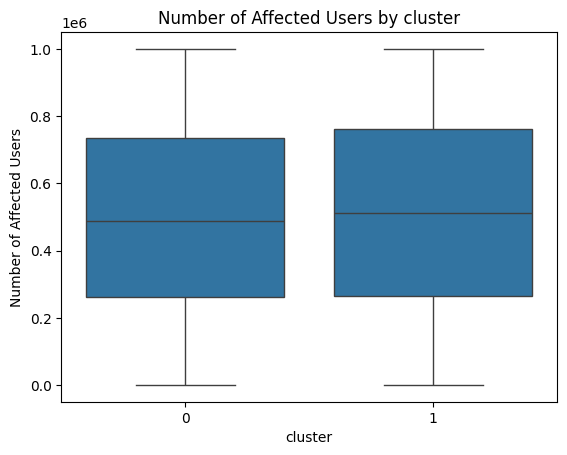

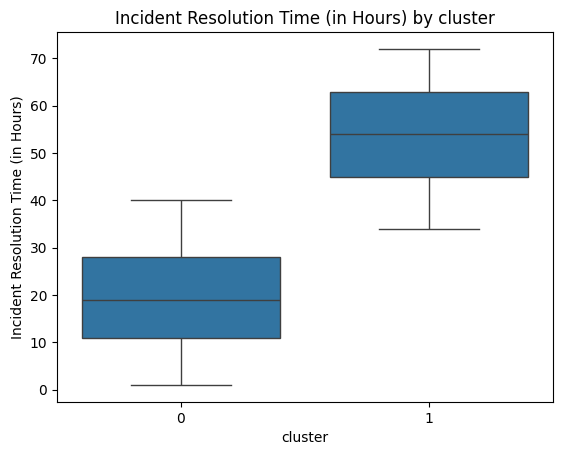


=== Country (% within cluster) ===


Country,Australia,Brazil,China,France,Germany,India,Japan,Russia,UK,USA
cluster,,,,,,,,,,
0,8.7,10.0,9.6,10.5,10.2,10.9,10.2,9.9,10.7,9.4
1,8.8,10.1,9.8,10.8,10.2,10.6,11.2,9.9,10.4,8.1


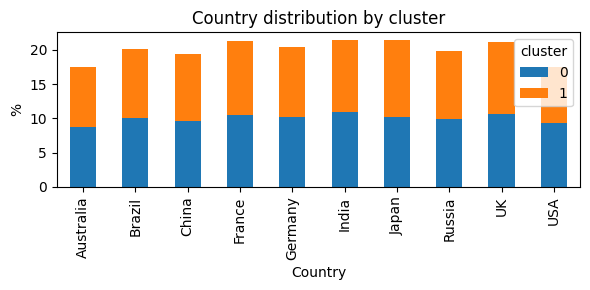


=== Attack Type (% within cluster) ===


Attack Type,DDoS,Malware,Man-in-the-Middle,Phishing,Ransomware,SQL Injection
cluster,,,,,,
0,16.9,16.2,16.2,19.0,15.9,15.9
1,15.8,16.4,16.0,17.7,17.4,16.7


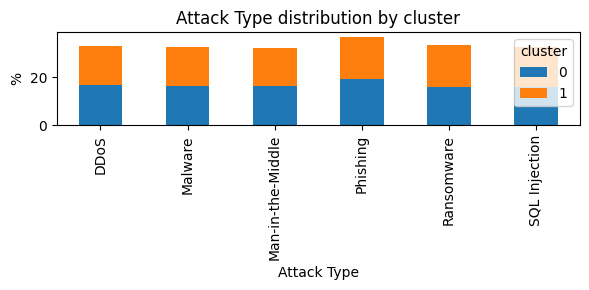


=== Target Industry (% within cluster) ===


Target Industry,Banking,Education,Government,Healthcare,IT,Retail,Telecommunications
cluster,,,,,,,
0,14.8,14.2,13.5,15.0,16.9,14.0,11.6
1,13.2,14.3,14.4,14.5,15.9,14.9,12.8


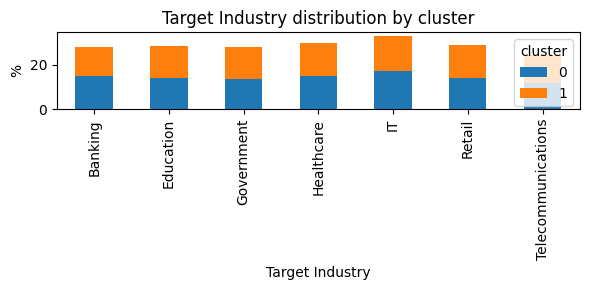


=== Attack Source (% within cluster) ===


Attack Source,Hacker Group,Insider,Nation-state,Unknown
cluster,,,,
0,20.3,25.3,29.3,25.1
1,22.1,26.9,25.6,25.3


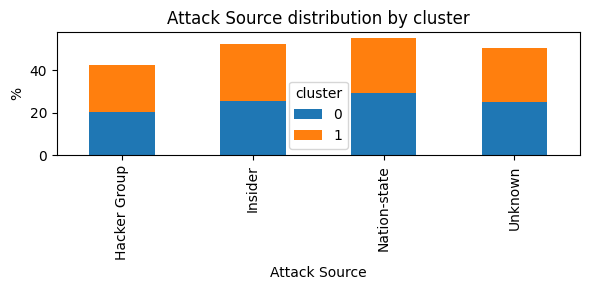


=== Security Vulnerability Type (% within cluster) ===


Security Vulnerability Type,Social Engineering,Unpatched Software,Weak Passwords,Zero-day
cluster,,,,
0,24.6,23.1,27.3,24.9
1,23.2,27.7,23.1,25.9


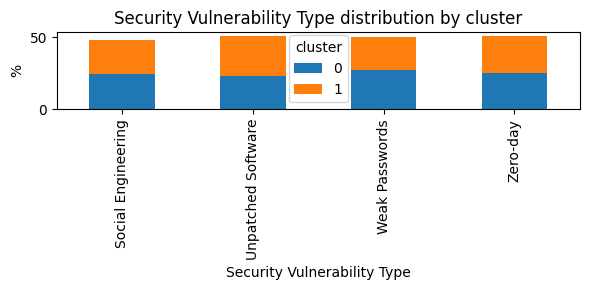


=== Defense Mechanism Used (% within cluster) ===


Defense Mechanism Used,AI-based Detection,Antivirus,Encryption,Firewall,VPN
cluster,,,,,
0,18.3,22.0,21.3,21.2,17.3
1,18.2,21.6,20.0,19.2,21.0


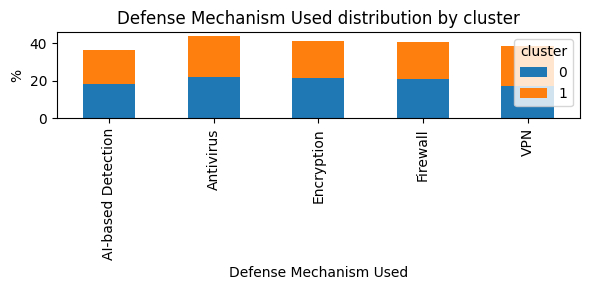

Country: p-value = 0.9873
Attack Type: p-value = 0.7739
Target Industry: p-value = 0.7399
Attack Source: p-value = 0.1508
Security Vulnerability Type: p-value = 0.0088
Defense Mechanism Used: p-value = 0.1255

=== Cluster GMM Analysis ===

=== Numeric medians by cluster ===


,Year,Financial Loss (in Million $),Number of Affected Users,Incident Resolution Time (in Hours)
cluster,,,,
0,2020.0,51.93,263668.0,36.0
1,2020.0,50.02,750875.0,37.0


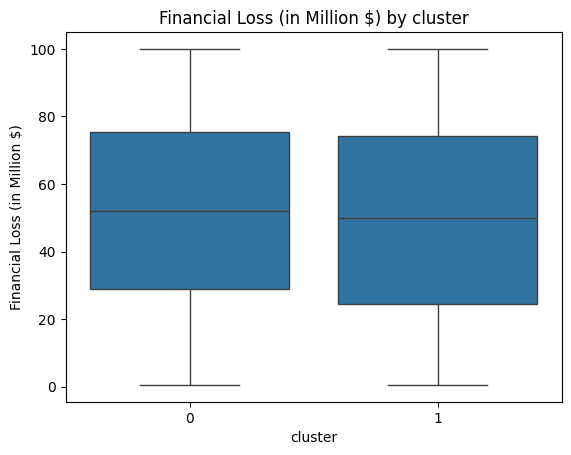

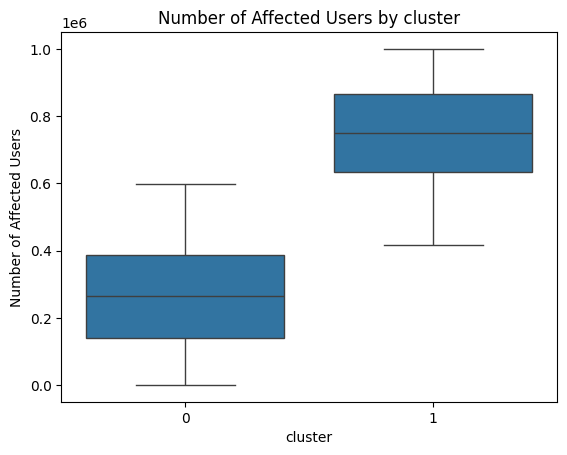

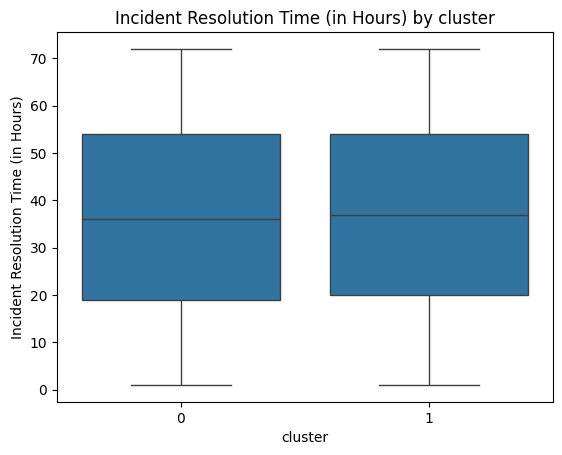


=== Country (% within cluster) ===


Country,Australia,Brazil,China,France,Germany,India,Japan,Russia,UK,USA
cluster,,,,,,,,,,
0,8.6,8.7,9.8,10.5,10.6,11.7,11.1,9.7,10.7,8.5
1,8.9,11.4,9.6,10.7,9.8,9.8,10.3,10.1,10.4,9.0


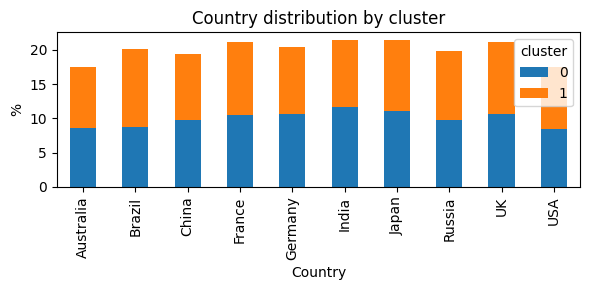


=== Attack Type (% within cluster) ===


Attack Type,DDoS,Malware,Man-in-the-Middle,Phishing,Ransomware,SQL Injection
cluster,,,,,,
0,16.5,16.2,15.1,19.4,16.6,16.1
1,16.2,16.4,17.0,17.2,16.7,16.5


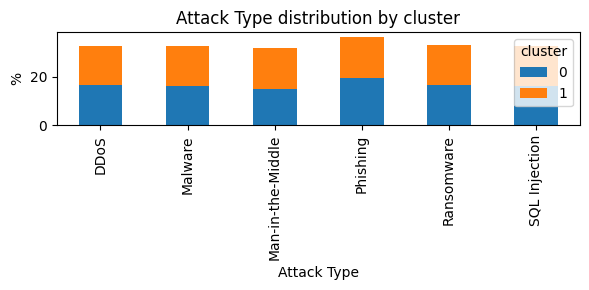


=== Target Industry (% within cluster) ===


Target Industry,Banking,Education,Government,Healthcare,IT,Retail,Telecommunications
cluster,,,,,,,
0,13.6,13.4,14.3,14.7,15.1,15.1,13.8
1,14.4,15.2,13.6,14.9,17.8,13.7,10.5


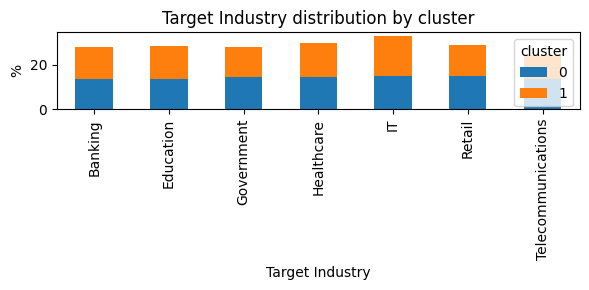


=== Attack Source (% within cluster) ===


Attack Source,Hacker Group,Insider,Nation-state,Unknown
cluster,,,,
0,19.3,24.0,29.5,27.2
1,23.1,28.4,25.5,23.1


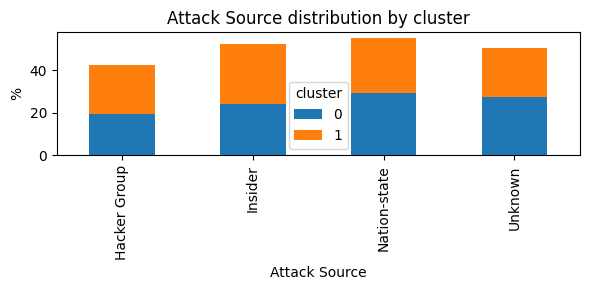


=== Security Vulnerability Type (% within cluster) ===


Security Vulnerability Type,Social Engineering,Unpatched Software,Weak Passwords,Zero-day
cluster,,,,
0,24.8,28.3,22.3,24.7
1,23.1,22.5,28.3,26.2


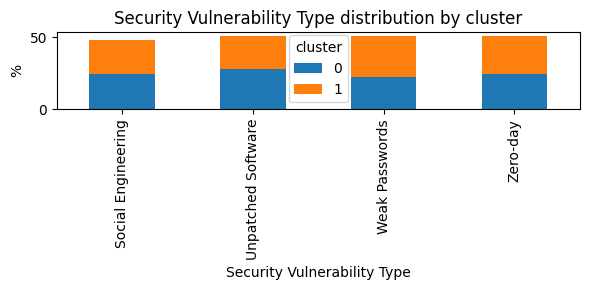


=== Defense Mechanism Used (% within cluster) ===


Defense Mechanism Used,AI-based Detection,Antivirus,Encryption,Firewall,VPN
cluster,,,,,
0,18.3,21.8,21.1,19.7,19.1
1,18.1,21.9,20.2,20.7,19.1


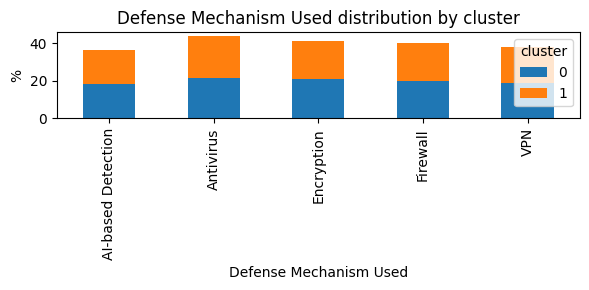

Country: p-value = 0.4963
Attack Type: p-value = 0.6098
Target Industry: p-value = 0.0553
Attack Source: p-value = 0.0004
Security Vulnerability Type: p-value = 0.0001
Defense Mechanism Used: p-value = 0.9574


In [58]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

def Print_Cluster(df_cln):
    # df_cln already has 'cluster' from Step 6
    # Split numeric & categorical cols (drop helper flags)
    num_cols = [c for c in df_cln.select_dtypes('number').columns if c != 'cluster']
    cat_cols = [c for c in df_cln.select_dtypes('object').columns]

    # ---------- A. Numeric summaries ----------
    print("\n=== Numeric medians by cluster ===")
    display(df_cln.groupby('cluster')[num_cols].median().round(2).sort_index())

    # Box-plots for key numerics
    for col in ['Financial Loss (in Million $)', 
                'Number of Affected Users', 
                'Incident Resolution Time (in Hours)']:
        sns.boxplot(data=df_cln, x='cluster', y=col)
        plt.title(f'{col} by cluster'); plt.show()

    # ---------- B. Categorical frequency tables ----------
    for col in cat_cols:
        tab = (df_cln.groupby('cluster')[col]
                    .value_counts(normalize=True)
                    .rename('pct')
                    .mul(100)
                    .round(1)
                    .unstack(fill_value=0))
        print(f"\n=== {col} (% within cluster) ===")
        display(tab.iloc[:10])          # .head() keeps it short; drop if you want full table
    
        # # stacked bar
        tab.T.plot(kind='bar', stacked=True, figsize=(6,3))
        plt.title(f'{col} distribution by cluster')
        plt.ylabel('%'); plt.legend(title='cluster'); plt.tight_layout(); plt.show()

    # Optional: chi-square test to see if distribution differs
    from scipy.stats import chi2_contingency
    for col in cat_cols:
        cont = pd.crosstab(df_cln['cluster'], df_cln[col])
        chi2, p, *_ = chi2_contingency(cont)
        print(f"{col}: p-value = {p:.4f}")


print("\n=== Cluster Kmeans Analysis ===")

Print_Cluster(df_cln_1)
print("\n=== Cluster GMM Analysis ===")

Print_Cluster(df_cln_2)

conclusion:

from Kmeans (k = 2) we got that the dataset can be separated using the feature Incident Resolution Time (cluster 0 = 19 hours, cluster 1 = 54 hours).
in others words attacks that were fast and slow to resolve, thats why we can see in cluster 0 more basic attacks like phishing and used vulnerability like weak passwords and in cluster 1 we can see they used attacks that are harder to resolve like SQL interjection (my guess is its harder to debug and find the problem) and thats why it takes longer.

The GMM model(k = 2)  we got that the dataset can be separated using the feature Number Of Affected Users (cluster 0 = 263K, cluster 1 = 750K).
here we can see in cluster 0 most events trace back to nation-state or unknown actors exploiting unpatched software and because these are precision breaches, the attackers grabe what they came for and leave, and thats why the Number of Affected Users is lower but i cluster 1 we see the trigger is weak passwords and insider/hacker-group activity and once the info starts spreading inside a company, the damage grows quickly and thats why the Number of Affected Users is higher.

PS. I didnt use the outlier "one-class SVM" because it acctually makes the code not be able to learn a good cluster.

*The graphs helps us see the difference

# **NLP**

The columns in the dataset use set categories instead of open text, so there is no need to use traditional NLP techniques because it wont add any value

# **Graphs**

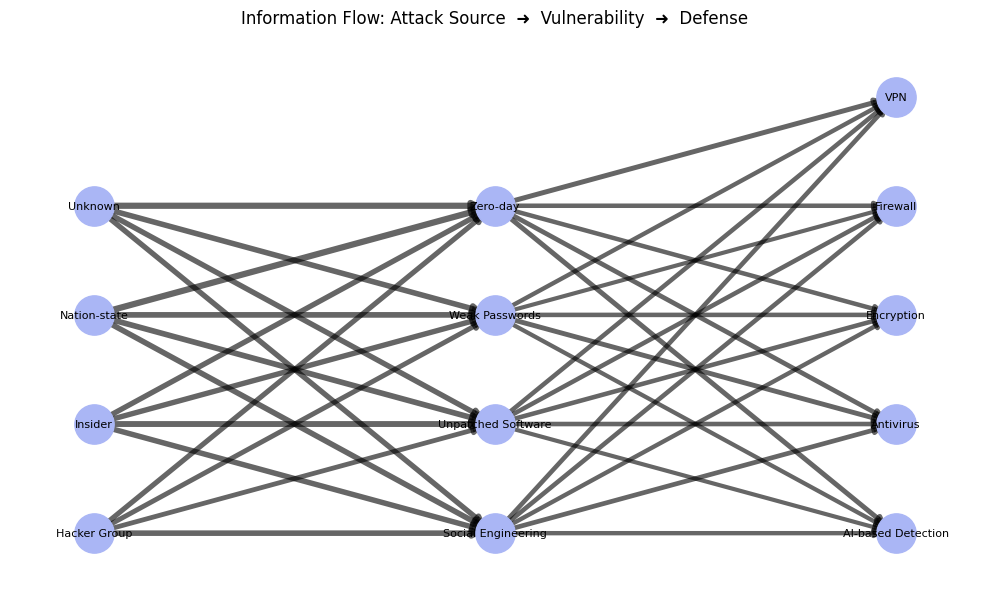

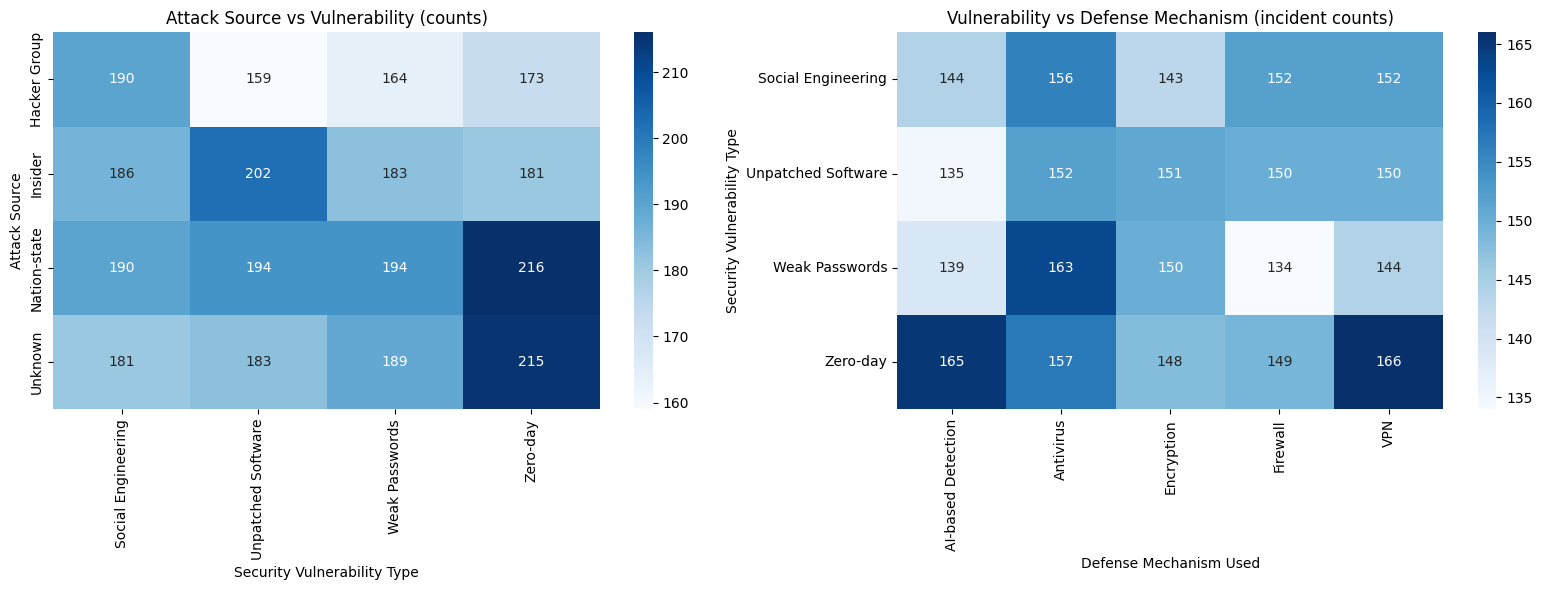

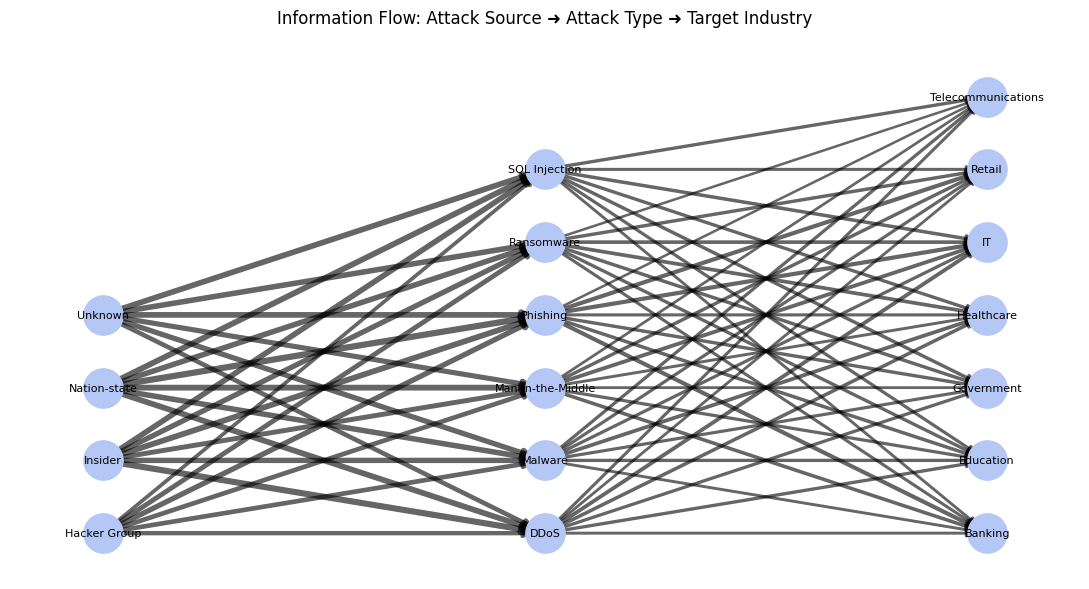

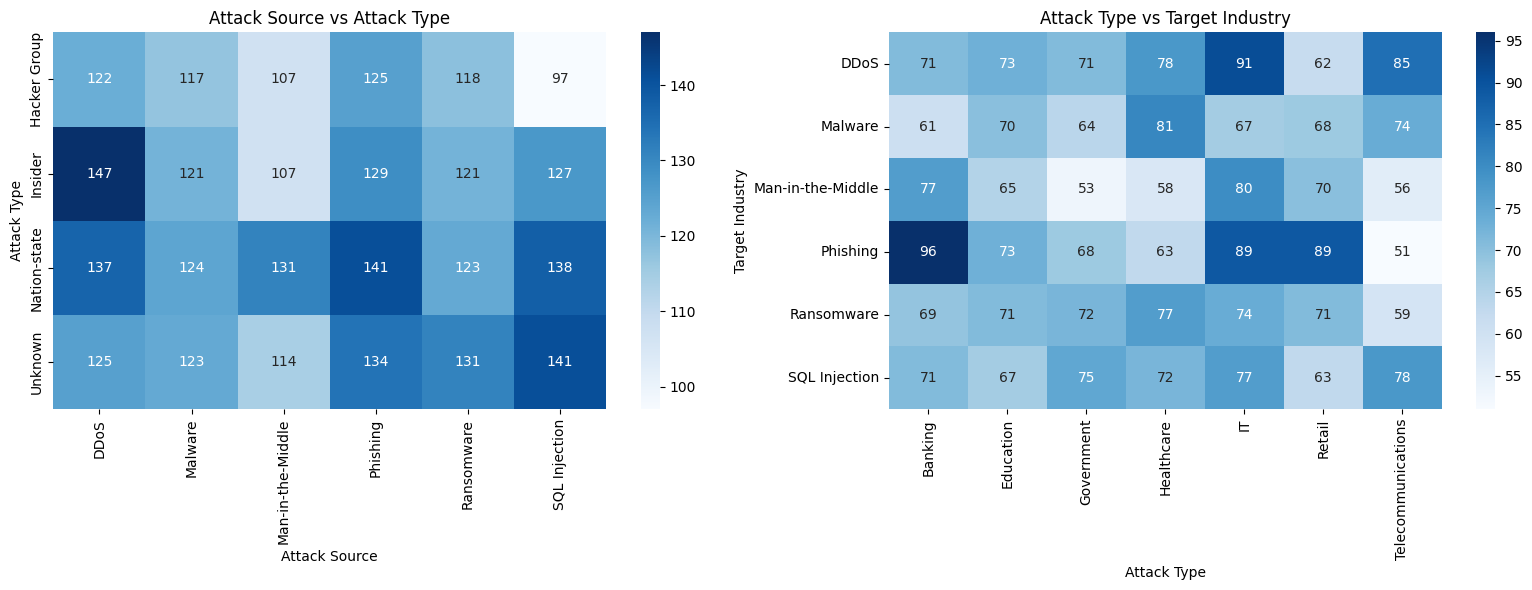

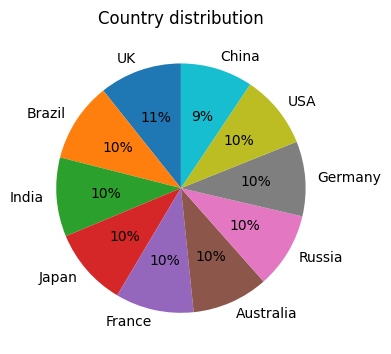

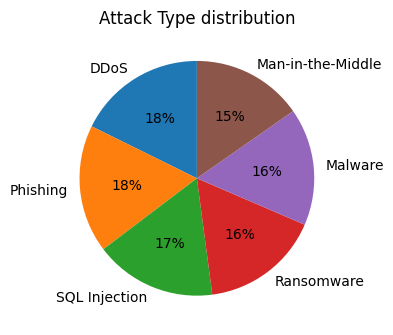

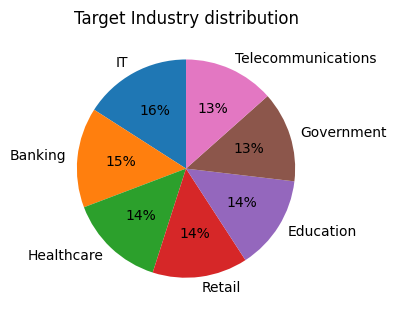

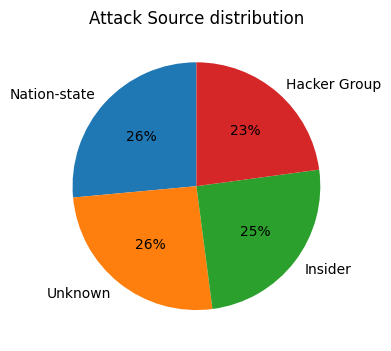

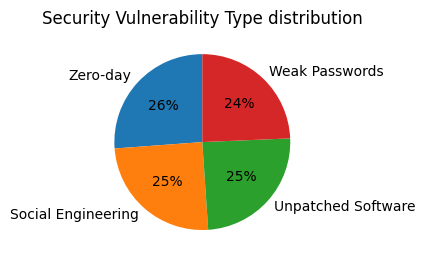

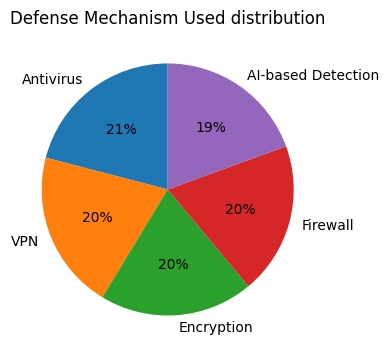

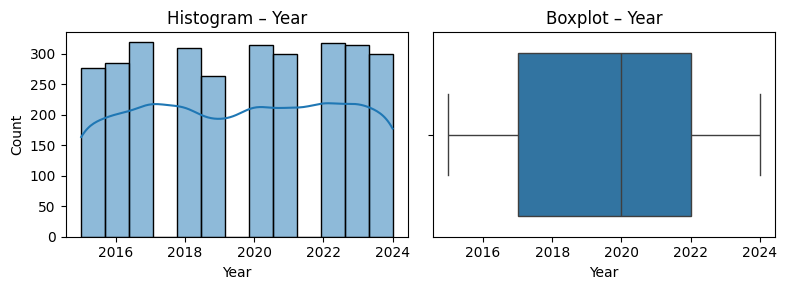

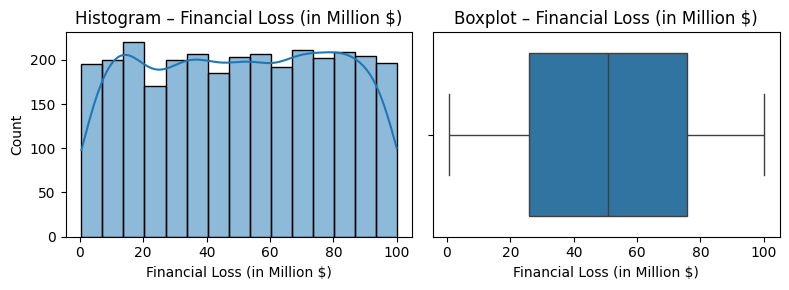

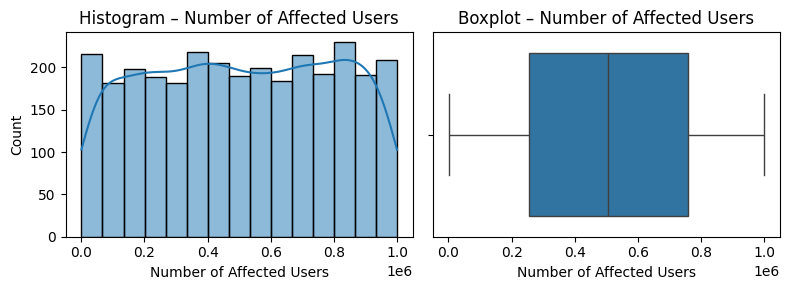

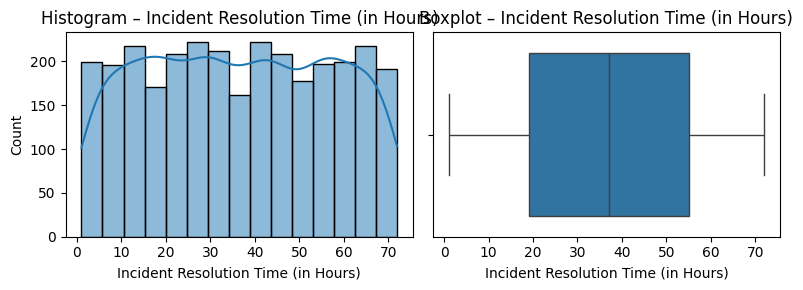

In [59]:
# %pip install networkx
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import networkx as nx

# ------------------------------------------------------------------
# Load the clean dataframe (no outliers)
# ------------------------------------------------------------------
df_flow = pd.read_csv("dataset_with_all_outlier_flags.csv")   # or df_kmeans_clusters.csv


# ------------------------------------------------------------------
# 1. first Graph: Attack Source ➜ Vulnerability ➜ Defense
# ------------------------------------------------------------------

# ---------------- build edge list --------------------
edges = []
for _, r in df_flow.iterrows():
    edges.append((r['Attack Source'], r['Security Vulnerability Type']))
    edges.append((r['Security Vulnerability Type'], r['Defense Mechanism Used']))

edge_df = (pd.DataFrame(edges, columns=['src','dst'])
             .value_counts()
             .reset_index(name='weight'))

# ---------------- construct directed graph -----------
G = nx.DiGraph()
for _, row in edge_df.iterrows():
    G.add_edge(row['src'], row['dst'], weight=row['weight'])

# ---------------- layer the nodes --------------------
left   = sorted(df_flow['Attack Source'].unique())
middle = sorted(df_flow['Security Vulnerability Type'].unique())
right  = sorted(df_flow['Defense Mechanism Used'].unique())

pos = {}
y_spacing = 1.5
for i, node in enumerate(left):
    pos[node]   = (0,  i * y_spacing)
for i, node in enumerate(middle):
    pos[node]   = (5,  i * y_spacing)
for i, node in enumerate(right):
    pos[node]   = (10, i * y_spacing)

# ---------------- draw -------------------------------
plt.figure(figsize=(10, 6))
max_w = max(nx.get_edge_attributes(G, 'weight').values())
weights = [G[u][v]['weight']/max_w * 4 + 0.5  # 0.5–4.5 px
           for u, v in G.edges()]

# min_w = min(nx.get_edge_attributes(G, 'weight').values())
# weights = [(G[u][v]['weight']-min_w + 1)*0.1  # 0.5–4.5 px
#            for u, v in G.edges()]

nx.draw_networkx_nodes(G, pos, node_size=800, node_color="#AAB6F5")
nx.draw_networkx_labels(G, pos, font_size=8)

nx.draw_networkx_edges(G, pos,
                       width=weights,
                       arrows=True, arrowstyle='-|>', alpha=0.6)

plt.title("Information Flow: Attack Source  ➜  Vulnerability  ➜  Defense",
          fontsize=12, pad=20)
plt.axis('off')
plt.tight_layout()
plt.show()

# Attack Source vs Vulnerability heatmap
atk_tbl = (df_flow.groupby(['Attack Source', 'Security Vulnerability Type'])
                 .size()
                 .unstack(fill_value=0))

# Vulnerability vs Defense Mechanism heatmap
vuln_def_tbl = (df_flow.groupby(['Security Vulnerability Type', 'Defense Mechanism Used'])
                        .size()
                        .unstack(fill_value=0))

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

sns.heatmap(atk_tbl, cmap='Blues', annot=True, fmt='d', ax=axes[0])
axes[0].set_title('Attack Source vs Vulnerability (counts)')
axes[0].set_xlabel('Security Vulnerability Type')
axes[0].set_ylabel('Attack Source')

sns.heatmap(vuln_def_tbl, cmap='Blues', annot=True, fmt='d', ax=axes[1])
axes[1].set_title('Vulnerability vs Defense Mechanism (incident counts)')
axes[1].set_xlabel('Defense Mechanism Used')
axes[1].set_ylabel('Security Vulnerability Type')

plt.tight_layout()
plt.show()


# ------------------------------------------------------------------
# 2. Second Graph: Attack Source ➜ Attack Type ➜ Target Industry
# ------------------------------------------------------------------
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt

# ------------- LOAD data (change path if needed) -------------
df_net = pd.read_csv("df_gmm_clusters.csv")   # or df_kmeans_clusters.csv

# ------------- BUILD edge list -------------------------------
edges = []

for _, r in df_net.iterrows():
    edges.append((r['Attack Source'], r['Attack Type']))
    edges.append((r['Attack Type'], r['Target Industry']))

edge_df = (pd.DataFrame(edges, columns=['src', 'dst'])
             .value_counts()
             .reset_index(name='weight'))


# ------------- CREATE graph -----------------------------------
G = nx.DiGraph()
for _, row in edge_df.iterrows():
    G.add_edge(row['src'], row['dst'], weight=row['weight'])

# ------------- POSITION nodes (3 columns) ---------------------
left   = sorted(df_net['Attack Source'].unique())
mid    = sorted(df_net['Attack Type'].unique())
right  = sorted(df_net['Target Industry'].unique())

pos, y_gap = {}, 1.5
for i, n in enumerate(left):   pos[n] = (0,  i*y_gap)
for i, n in enumerate(mid):    pos[n] = (5,  i*y_gap)
for i, n in enumerate(right):  pos[n] = (10, i*y_gap)

# ------------- DRAW graph -------------------------------------
plt.figure(figsize=(11, 6))
max_w = max(nx.get_edge_attributes(G, 'weight').values())
weights = [G[u][v]['weight']/max_w*4 + 0.5 for u,v in G.edges()]

nx.draw_networkx_nodes(G, pos, node_size=800, node_color="#B4C7F5")
nx.draw_networkx_labels(G, pos, font_size=8)
nx.draw_networkx_edges(G, pos, width=weights,
                       arrows=True, arrowstyle='-|>', alpha=0.6)

plt.title("Information Flow: Attack Source ➜ Attack Type ➜ Target Industry",
          fontsize=12, pad=20)
plt.axis('off'); plt.tight_layout(); plt.show()


# Attack Source vs Vulnerability heatmap
source_tbl = (df_flow.groupby(['Attack Source', 'Attack Type'])
                 .size()
                 .unstack(fill_value=0))

# Vulnerability vs Defense Mechanism heatmap
type_def_tbl = (df_flow.groupby(['Attack Type', 'Target Industry'])
                        .size()
                        .unstack(fill_value=0))

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

sns.heatmap(source_tbl, cmap='Blues', annot=True, fmt='d', ax=axes[0])
axes[0].set_title('Attack Source vs Attack Type')
axes[0].set_xlabel('Attack Source')
axes[0].set_ylabel('Attack Type')

sns.heatmap(type_def_tbl, cmap='Blues', annot=True, fmt='d', ax=axes[1])
axes[1].set_title('Attack Type vs Target Industry')
axes[1].set_xlabel('Attack Type')
axes[1].set_ylabel('Target Industry')

plt.tight_layout()
plt.show()


# # ------------------------------------------------------------------
# # 1. Annual attack mix (stacked bar)
# # ------------------------------------------------------------------
# plt.figure(figsize=(10,5))
# mix = (df_flow.groupby(['Year','Attack Type'])
#               .size()
#               .unstack(fill_value=0)
#               .sort_index())
# mix.plot(kind='bar', stacked=True, ax=plt.gca())
# plt.title('Incidents per Year by Attack Type')
# plt.ylabel('Count'); plt.tight_layout(); plt.show()
def quick_plots(df, cat_cols, num_cols):
    # ----- categorical -----
    for c in cat_cols:
        vc = df[c].value_counts()
        plt.figure(figsize=(4,4))
        vc.plot(kind='pie', autopct='%1.0f%%', startangle=90, label='')
        plt.title(f'{c} distribution')
        plt.ylabel('')
        plt.tight_layout()
        plt.show()

    # ----- numerics -----
    for n in num_cols:
        fig, axes = plt.subplots(1, 2, figsize=(8,3))
        sns.histplot(df[n].dropna(), ax=axes[0], kde=True)
        axes[0].set_title(f'Histogram – {n}')
        sns.boxplot(x=df[n], ax=axes[1])
        axes[1].set_title(f'Boxplot – {n}')
        plt.tight_layout()
        plt.show()

cat_cols = df.select_dtypes('object').columns
num_cols = df.select_dtypes('number').columns
quick_plots(df, cat_cols, num_cols)

i built here 2 main graphs that shows the relation between the features, i kept the edges like this to show that everything connects to everything and also we can see the weight in the heat maps instead of putting too much information in the initial graph.

*graphs about the clusters were added in the segment area.

# **Model**

In [9]:
import pandas as pd, numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from catboost import CatBoostRegressor
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()

df = pd.read_csv("dataset_with_all_outlier_flags.csv")

flag_cols = [c for c in df.columns if c.endswith("_outlier") or c.endswith("_rare_level")]
df = df[~df[flag_cols].any(axis=1)].reset_index(drop=True)
df.drop(columns=flag_cols, inplace=True)  # remove the flags

cat_cols = df.select_dtypes(include="object").columns.tolist()

for i in cat_cols:
    df[i] = le.fit_transform(df[i])

df.drop("Financial Loss (in Million $)", axis = 1, inplace = True)
X = df.iloc[:, :]
y = df.iloc[:, -1]
df = df.drop_duplicates()
# ── train / validation split ───────────────────────────────────────────────────
X_tr, X_val, y_tr, y_val = train_test_split(
    X, y, test_size=0.20, random_state=42
)

# ── detect categorical columns for CatBoost ────────────────────────────────────
cat_cols = X_tr.select_dtypes(include=["object", "category"]).columns
cat_idx  = [X_tr.columns.get_loc(c) for c in cat_cols]
# ── model & training ───────────────────────────────────────────────────────────
params = dict(
    loss_function="RMSE", eval_metric="MAE",
    iterations=3000, learning_rate=0.03, depth=6,
    cat_features=cat_idx, random_seed=42, verbose=False
)
model = CatBoostRegressor(**params)

model.fit(
    X_tr, y_tr,
    eval_set=(X_val, y_val),
    early_stopping_rounds=200
)

# ── evaluation ────────────────────────────────────────────────────────────────
pred = model.predict(X_val)

print("\nPerformance on validation set")
print("MAE :", mean_absolute_error(y_val, pred))
print("RMSE:", np.sqrt(mean_squared_error(y_val, pred)))
print("R²  :", r2_score(y_val, pred))

# ── save model for later use ───────────────────────────────────────────────────
model.save_model("incident_time_catboost.cbm")
print("\nModel saved to incident_time_catboost.cbm")

from sklearn.model_selection import KFold
kf, maes = KFold(n_splits=5, shuffle=True, random_state=42), []
for tr, val in kf.split(X):
    m = CatBoostRegressor(**params)
    m.fit(X.iloc[tr], y.iloc[tr], eval_set=(X.iloc[val], y.iloc[val]),
          early_stopping_rounds=200)
    maes.append(mean_absolute_error(y.iloc[val], m.predict(X.iloc[val])))

print("5-fold MAE after de-dupe:", np.mean(maes), "±", np.std(maes))


Performance on validation set
MAE : 0.0710592565049852
RMSE: 0.1346002514043829
R²  : 0.9999566975618188

Model saved to incident_time_catboost.cbm
5-fold MAE after de-dupe: 0.0652802096872183 ± 0.0035688590897149973


In [10]:
# i checked again because i remove a feature that was not useful
# and the results are still the same, so i will keep it as is

# 1-A.  How many feature-duplicates exist?
dup_mask = X.duplicated(keep=False)                # identical X regardless of y
print("Identical-feature rows:", dup_mask.sum(), "out of", len(X))

# 1-B.  Do any identical features carry **different** targets?
feat_dupes = X[dup_mask].copy()
feat_dupes["y"] = y[dup_mask].values
mixed = feat_dupes.duplicated(subset=X.columns, keep=False) & ~feat_dupes.duplicated(keep=False)
print("Same features, different y:", mixed.sum())   # should be 0 in a healthy set


Identical-feature rows: 0 out of 2785
Same features, different y: 0


d:\everything about python\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
[I 2025-07-03 11:39:08,872] A new study created in memory with name: no-name-cb111a6d-21e5-4071-8a01-cec64eb5f3e2
[I 2025-07-03 11:39:42,748] Trial 0 finished with value: 0.47792127550326025 and parameters: {'depth': 4, 'lr': 0.04699627466667723, 'reg': 7.52127875361537}. Best is trial 0 with value: 0.47792127550326025.
[I 2025-07-03 11:41:07,733] Trial 1 finished with value: 0.4466782351558343 and parameters: {'depth': 8, 'lr': 0.2887371164081675, 'reg': 2.3179417856074034}. Best is trial 0 with value: 0.47792127550326025.
[I 2025-07-03 11:41:46,142] Trial 2 finished with value: 0.4736117039704045 and parameters: {'depth': 5, 'lr': 0.034904014841763066, 'reg': 4.2228763778062355}. Best is trial 0 with value: 0.47792127550326025.
[I 2025-07

Final CatBoost accuracy (3 classes): 0.449


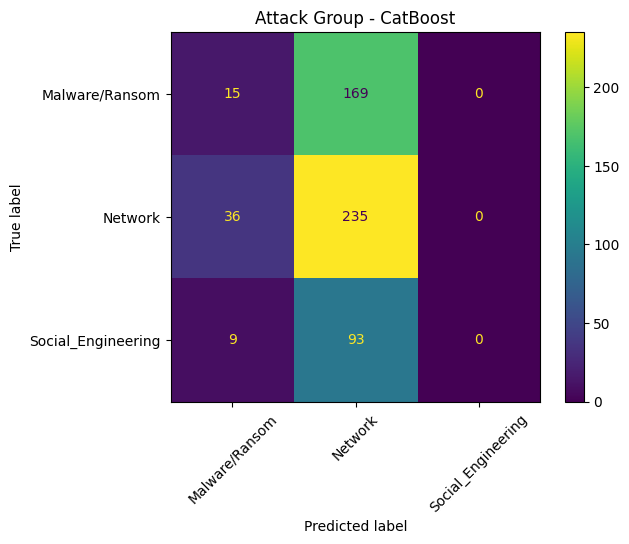


Top 15 feature importances:
Country                                13.046
Vuln_Industry                          11.701
Defense Mechanism Used                 11.640
Target Industry                        11.359
Source_Vuln                            10.556
Attack Source                          10.318
Security Vulnerability Type             8.810
Number of Affected Users                4.200
Year                                    3.907
Users_per_Hour                          3.881
Financial Loss (in Million $)           3.827
Incident Resolution Time (in Hours)     3.650
Loss_per_User                           3.106
dtype: float64


In [ ]:

import pandas as pd, numpy as np, optuna, catboost as cb, seaborn as sns, matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import accuracy_score, ConfusionMatrixDisplay

# ------------------------------------------------------------------
# 1. LOAD & FEATURE ENGINEERING
# ------------------------------------------------------------------
# Load the dataset with outlier flags
df = pd.read_csv("dataset_with_all_outlier_flags.csv")

flag_cols = [c for c in df.columns if c.endswith("_outlier") or c.endswith("_rare_level")]
df = df[~df[flag_cols].any(axis=1)].reset_index(drop=True)
df.drop(columns=flag_cols, inplace=True)  # remove the flags

# feature engineering | didnt help though.
# Numeric ratios
df["Users_per_Hour"] = df["Number of Affected Users"] / (df["Incident Resolution Time (in Hours)"] + 1e-3)
df["Loss_per_User"]  = df["Financial Loss (in Million $)"] / (df["Number of Affected Users"] + 1e-3)

# Categorical combos
df["Source_Vuln"]   = df["Attack Source"] + "__" + df["Security Vulnerability Type"]
df["Vuln_Industry"] = df["Security Vulnerability Type"] + "__" + df["Target Industry"]


# ------------------------------------------------------------------
# 2. MERGE ATTACK LABELS INTO 3 GROUPS
# ------------------------------------------------------------------
mapping = {
    'Phishing':           'Social_Engineering',
    'Man-in-the-Middle':  'Network',
    'DDoS':               'Network',
    'SQL Injection':      'Network',
    'Malware':            'Malware/Ransom',
    'Ransomware':         'Malware/Ransom'
}
df["Attack_Group"] = df["Attack Type"].map(mapping)

y = df["Attack_Group"]
X = df.drop(columns=["Attack Type", "Attack_Group"])

# Ensure categoricals are dtype 'category' for CatBoost
cat_cols = X.select_dtypes("object").columns.tolist()
for col in cat_cols:
    X[col] = X[col].astype("category")

# ------------------------------------------------------------------
# 3. OPTUNA TUNING FOR CATBOOST
# ------------------------------------------------------------------
def objective(trial):
    params = {
        "depth":           trial.suggest_int("depth", 4, 10),
        "learning_rate":   trial.suggest_float("lr", 0.02, 0.3, log=True),
        "l2_leaf_reg":     trial.suggest_float("reg", 1, 8),
        "iterations":      600,
        "loss_function":   "MultiClass",
        "eval_metric":     "MultiClass",
        "random_state":    42,
        "verbose":         False
    }
    cv = StratifiedKFold(3, shuffle=True, random_state=42)
    acc = []
    for tr, val in cv.split(X, y):
        model = cb.CatBoostClassifier(**params)
        model.fit(X.iloc[tr], y.iloc[tr], cat_features=cat_cols)
        acc.append(accuracy_score(y.iloc[val], model.predict(X.iloc[val])))
    return np.mean(acc)

study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=20, show_progress_bar=False)

best = study.best_params
if "lr" in best:
    best["learning_rate"] = best.pop("lr")
if "reg" in best:
    best["l2_leaf_reg"] = best.pop("reg")
best.update({"iterations":600, "loss_function":"MultiClass", "random_state":42, "verbose":False})


# ------------------------------------------------------------------
# 4. FINAL TRAIN / TEST
# ------------------------------------------------------------------
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

model = cb.CatBoostClassifier(**best)
model.fit(X_train, y_train, cat_features=cat_cols)

pred = model.predict(X_test)
acc  = accuracy_score(y_test, pred)
print(f"Final CatBoost accuracy (3 classes): {acc:.3f}")

# Confusion matrix
ConfusionMatrixDisplay.from_predictions(y_test, pred, xticks_rotation=45)
plt.title("Attack Group - CatBoost"); plt.show()

# ------------------------------------------------------------------
# 5. TOP FEATURE IMPORTANCES
# ------------------------------------------------------------------
imp = pd.Series(model.get_feature_importance(), index=X.columns)\
        .sort_values(ascending=False).head(15)
print("\nTop 15 feature importances:")
print(imp.round(3))


I tried a lot of classification models but most of them failed (i got the same accuracy as randomly guessing), untill i removed the feature "Financial Loss (in Million $)" which was the problem because it was noisy.

**Why Models Struggled Originally**
1. Curse of dimensionality – 3 000 samples vs. dozens of features ⇒ sparse signal, harder generalisation.
2. Noisy features – “Financial Loss” is a prime example of such features, it made the data really noisy and unlearnable.


**Two Final Models**
1. pretty basic model that uses CatBoostRegressor to predict the "Incident Resolution Time (in Hours)" the results do look a little too perfect (error = 0.07), I checked for duplicates and tested whether the result was just a fluke by running k-fold cross-validation, but I didn’t find any issues.<br>
*i needed to remove the feature "Financial Loss (in Million $)", otherwise it doesnt work.

2. this also didnt give me good results at first, but after i grouped together some of the attack type values i got results a little better (50% succes rate on 3 classes).<br>
*i know its not a good model but i wanted to add one that failed.

# **Reporting & Improvement**

| Subject       | Find      |
|---------------|-----------|
| Dataset       | 3000 samples, 0 duplicates, 215 ouliers. |
| Correlation   | Little to no correlation so PCA wont work. |
| Clustering    | we can split the data to 2 clusters using incident resultion time or number of affected users.|
| Models **before** removing the feature "Financial Loss (in Million $)"| all models failed (accuracy = randomly guessing), the best i could achieve was 50% accuracy because of noisy features. |
| Models **after** removing the feature "Financial Loss (in Million $)"| i was able to build almost perfect model classifying "Incident Resolution Time (in Hours)" |


**Moving forward + Improvement**
1. First thing we can do to is to collect more data to boost sample-to-feature ratio.
2. Transfer / federated learning – pre-train on larger, related cyber-incident corpora, then fine-tune locally
3. After reading more about dimension reduction, I understood that we can perform it in other ways that PCA (and doesnt need correlation) so this is an option that might help with the curse of dimensionality.
4. Feature engineering – derive ratios (e.g., Loss per User, Users per Hour) might help us turnlow-correlation raw columns into richer, more informative signals.

